In [ ]:
# ML_in_Finance-G-learning-wealth-management
# Author: Igor Halperin
# Version: 1.0 (12.8.2019)
# License: MIT
# Email: ighalp@gmail.com
# Notes: tested on Mac OS X with Python 3.6 and Tensorflow 1.3.0
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and I. Halperin, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 

## G-learning for wealth optimization

Using G-learning with quadratic rewards for optimization of defined contribution retirement plan

In [1]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt 
%matplotlib inline

import numpy as np
import time

#To ignore warnings that are annoying.
import warnings
warnings.filterwarnings('ignore')

In [2]:
class G_learning_portfolio_opt:
    
    def __init__(self, 
                 num_steps,
                 lambd, 
                 Omega_mat, # of shape (num_risky_assets + 1)x(num_risky_assets + 1) 
                 beta,
                 gamma, 
                 num_risky_assets,
                 riskfree_rate,
                 exp_returns, # array of shape num_steps x num_stocks
                 Sigma_r,     # covariance matrix of returns of risky assets
                 init_x_vals, # array of initial asset position values (num_risky_assets + 1)
                 use_for_WM = True, # use for wealth management tasks
                 target_portf=None):
        
        
        self.num_steps = num_steps
        self.lambd = lambd
        
        #self.eta = eta
        self.Omega_mat = Omega_mat
        
        self.beta = beta
        self.gamma = gamma
        self.use_for_WM = use_for_WM
        
        self.num_risky_assets = num_risky_assets
        self.r_f = riskfree_rate
        
        self.num_assets = num_risky_assets + 1 # exp_returns.shape[1]
        
        assert exp_returns.shape[0] == self.num_steps
        assert Sigma_r.shape[0] == Sigma_r.shape[1]
        assert Sigma_r.shape[0] == num_risky_assets # self.num_assets
        
        self.Sigma_r = Sigma_r # array of shape num_stocks x num_stocks
        
        # arrays of returns for all assets including the risk-free asset
        # array of shape num_steps x (num_stocks + 1) 
        self.exp_returns = np.hstack((self.r_f * np.ones(self.num_steps).reshape((-1,1)), exp_returns))
                                      
        # make block-matrix Sigma_r_tilde with Sigma_r_tilde[0,0] = 0, and equity correlation matrix inside
        self.Sigma_r_tilde = np.zeros((self.num_assets, self.num_assets))
        self.Sigma_r_tilde[1:,1:] = self.Sigma_r
        
        # asset holding values for all times. Initialize with initial values, 
        # values for the future times will be expected values 
        self.x_vals = np.zeros((self.num_steps, self.num_assets))
        self.x_vals[0,:] = init_x_vals 
        
        if self.use_for_WM:
                self.target_portf = target_portf
                assert len(self.target_portf) == self.num_steps
#       else:
#           raise (RuntimeError, "A target portfolio profile is required")
                
        # allocate memory for coefficients of F- and G-functions
        self.F_xx = np.zeros((self.num_steps, self.num_assets, self.num_assets))
        self.F_x = np.zeros((self.num_steps, self.num_assets))
        self.F_0 = np.zeros(self.num_steps)
        
        self.Q_xx = np.zeros((self.num_steps, self.num_assets, self.num_assets))
        self.Q_uu = np.zeros((self.num_steps, self.num_assets, self.num_assets))
        self.Q_ux = np.zeros((self.num_steps, self.num_assets, self.num_assets))
        self.Q_x = np.zeros((self.num_steps, self.num_assets))
        self.Q_u = np.zeros((self.num_steps, self.num_assets))
        self.Q_0 = np.zeros(self.num_steps)
        
        # optimal actions for all assets (only used for the final step)
#         self.opt_action = np.zeros((self.num_steps,self.num_assets))
        
        # initialize time-dependent parameters of prior policy 
        self.u_bar_prior = np.zeros((self.num_steps,self.num_assets))
        self.v_bar_prior =  np.zeros((self.num_steps, self.num_assets, self.num_assets))
        self.Sigma_prior =  np.zeros((self.num_steps, self.num_assets, self.num_assets))
        self.Sigma_prior_inv = np.zeros((self.num_steps, self.num_assets, self.num_assets))
        
        # make each time elements of v_bar_prior and Sigma_prior proportional to the unit matrix
        for t in range(self.num_steps):
            self.v_bar_prior[t,:,:] = 0.1 * np.eye(self.num_assets)
            self.Sigma_prior[t,:,:] = 0.1 * np.eye(self.num_assets)
            self.Sigma_prior_inv[t,:,:] = np.linalg.inv(self.Sigma_prior[t,:,:])
            
        # expected cash installment for all steps
        self.expected_c_t = np.zeros(self.num_steps)
        
        # expected portfolio values for all times
        self.expected_portf_val = np.zeros(self.num_steps)
        
        # the first value is the sum of initial position values
        self.expected_portf_val[0] = np.sum(self.x_vals[0,:])
    
    def reward_fun(self, t, x_vals, u_vals, exp_rets, lambd, Sigma_hat):
        """
        The reward function 
        """
        x_plus = x_vals + u_vals
        aux_1 = - self.lambd * self.target_portf[t]**2
        aux_2 = - np.sum(u_vals)
        aux_3 = 2*self.lambd * self.target_portf[t] * x_plus.dot(np.ones(num_assets) + exp_rets)
        aux_4 = - self.lambd * x_plus.dot(Sigma_hat.dot(x_plus))
        aux_5 = - u.dot(self.Omega_mat.dot(u))
        
        return aux_1 + aux_2 + aux_3 + aux_4 + aux_5  
    
    def project_cash_injections(self):
        """
        Compute the expected values of future asset positions, and the expected cash injection for future steps
        """
        
        # this assumes that the policy is trained
        for t in range(1, self.num_steps):  # the initial value is fixed 
            
            # increment the previous x_t
            
            delta_x_t = self.u_bar_prior[t,:] + self.v_bar_prior[t,:,:].dot(self.x_vals[t-1,:])
            self.x_vals[t,:] = self.x_vals[t-1,:] + delta_x_t
            
            # grow using the expected return
            self.x_vals[t,:] = (np.ones(self.num_assets)+ self.exp_returns[t,:])*self.x_vals[t,:]
            
            # compute c_t
            self.expected_c_t[t] = np.sum(delta_x_t)
            
            # expected portfolio value for this step
            self.expected_portf_val[t] = np.sum(self.x_vals[t,:])
            
                                                                                      
    def set_terminal_conditions(self):
        """
        set the terminal condition for the F-function
        """
        
        # auxiliary quantities to perform matrix calculations
        exp_ret_T = self.exp_returns[-1,:]
        exp_ret_T_v = exp_ret_T[:, np.newaxis]
        one_plus_exp_ret = np.ones(self.num_assets)[:,np.newaxis] + exp_ret_T_v
        
        if self.use_for_WM:
            # Sigma_hat = self.Sigma_r + one_plus_exp_ret.dot(one_plus_exp_ret.T)
            Sigma_hat = self.Sigma_r_tilde + one_plus_exp_ret.dot(one_plus_exp_ret.T)
            
            Sigma_hat_inv = np.linalg.pinv(Sigma_hat)
            
            #Sigma_tilde = Sigma_hat + (self.eta/self.lambd)*np.eye(self.num_assets)
            Sigma_tilde = Sigma_hat + (1/self.lambd)*self.Omega_mat
            
            Sigma_tilde_inv = np.linalg.pinv(Sigma_tilde)
            
            Sigma_hat_sigma_tilde = Sigma_hat.dot(Sigma_tilde)
            Sigma_tilde_inv_sig_hat = Sigma_tilde_inv.dot(Sigma_hat)
            
            Sigma_tilde_sigma_hat = Sigma_tilde.dot(Sigma_hat)
            
            Theta_m = np.eye(self.num_assets) - Sigma_tilde_inv.dot(Sigma_hat) 
            
            P_T = self.target_portf[-1]
    
            # P_tilde is a column vector
            P_tilde = P_T * one_plus_exp_ret - (1.0/(2*self.lambd))*np.ones(self.num_assets)[:,np.newaxis]
                           
            # compute P_aux \equiv P_tilde - Sigma_hat.dot(x)
            #P_aux_1 = Sigma_hat.dot(self.x_vals[-1,:])
            #P_aux = P_tilde - P_aux_1[:,np.newaxis]
            
            # the last action
            #self.opt_action[-1,:] = Sigma_tilde_inv.dot(P_aux.reshape(-1))
            
            # though the action at the last step is deterministic, we can feed 
            # parameters of the prior with these values
            self.u_bar_prior[-1,:] = Sigma_tilde_inv.dot(P_tilde.reshape(-1))
            self.v_bar_prior[-1,:,:] = - Sigma_tilde_inv.dot(Sigma_hat)
            
            #self.c_t[-1] = np.sum(self.opt_action[-1,:])
            
            # the coefficients of F-function for the last step
            
            # F_xx
#             self.F_xx[-1,:,:] = (- self.lambd*Sigma_hat.dot(np.eye(self.num_assets)
#                                                            - Sigma_tilde_inv.dot(Sigma_hat)))
            self.F_xx[-1,:,:] = (- self.lambd * Theta_m.T.dot(Sigma_hat.dot(Theta_m))
                                 - Sigma_tilde_inv_sig_hat.T.dot(self.Omega_mat.dot(Sigma_tilde_inv_sig_hat))
                                 )
                                 
                                 
            
            # F_x
            Sigma_hat_Sigma_tilde_inv = Sigma_hat.dot(Sigma_tilde_inv)
            
            #One_minus_Sigma_hat_til = np.eye(self.num_assets) - Sigma_hat_Sigma_til # Use Theta_m
            
#             self.F_x[-1,:] =  (Sigma_hat_Sigma_til.dot(np.ones(self.num_assets))+ 
#                                2*self.lambd*self.target_portf[-1]*
#                                One_minus_Sigma_hat_til.dot(one_plus_exp_ret.reshape(-1)))
            
            aux_1x = Sigma_hat_Sigma_tilde_inv.dot(np.ones(self.num_assets))
            aux_2x = 2*self.lambd * P_T * Theta_m.T.dot(one_plus_exp_ret.reshape(-1))
            aux_3x = - 2*self.lambd * (Theta_m.T.dot(Sigma_hat_Sigma_tilde_inv.dot(P_tilde))).reshape(-1)
            aux_4x = 2 * (Sigma_hat_Sigma_tilde_inv.dot(self.Omega_mat.dot(Sigma_tilde_inv.dot(P_tilde)))).reshape(-1)
            #print('In  set_terminal_conditions: aux_1x etc shapes:')
            #print(aux_1x.shape,aux_2x.shape, aux_3x.shape,aux_4x.shape)
    
    
            self.F_x[-1,:] = aux_1x + aux_2x + aux_3x + aux_4x
        
#             self.F_x[-1,:] =  (Sigma_hat_Sigma_tilde_inv.dot(np.ones(self.num_assets))
#                                + 2*self.lambd * P_T * Theta_m.T.dot(one_plus_exp_ret.reshape(-1)).reshape(-1)
#                                - 2*self.lambd * Theta_m.T.dot(Sigma_hat_Sigma_tilde_inv.dot(P_tilde)).reshape(-1)
#                                + 2*Sigma_hat_Sigma_tilde_inv.dot(self.Omega_mat.dot(Sigma_tilde_inv.dot(P_tilde)))
#                               )
        

            #print('self.F_x[-1,:].shape = ', self.F_x[-1,:].shape) 
            
            # F_0
            P_tilde_Sigma_aux = P_tilde.reshape(-1).dot(Sigma_tilde_inv)
            Sigma_P_tilde_aux =  Sigma_tilde_inv.dot(P_tilde.reshape(-1)) # P_tilde_Sigma_aux.T #
            
            
#             self.F_0[-1] = (P_tilde_Sigma_aux.dot(np.ones(self.num_assets))
#                             - self.lambd * P_tilde_Sigma_aux.dot(self.P_tilde.reshape(-1))
#                             + 2*self.lambd * one_plus_exp_ret.reshape(-1).dot(Sigma_P_tilde_aux)
#                             - self.lambd * P_T**2)
 
            aux_0 = - self.lambd * P_T**2
            aux_1 =  - P_tilde.T.dot(Sigma_tilde_inv.dot(np.ones(self.num_assets)))[0] # this is a matrix of size 1x1        
            aux_2 = 2*self.lambd * P_T * one_plus_exp_ret.reshape(-1).dot(Sigma_P_tilde_aux)
            aux_3 = - self.lambd * P_tilde_Sigma_aux.dot(Sigma_hat.dot(Sigma_P_tilde_aux))
            aux_4 =  -  P_tilde_Sigma_aux.dot(self.Omega_mat.dot(Sigma_P_tilde_aux))
    
            #print('In set_terminal_conditions: shapes')
            #print(aux_1.shape, aux_2.shape, aux_3.shape, aux_4.shape)
            #print('aux_1 = ', aux_1)
        
            self.F_0[-1] =  aux_0 + aux_1 + aux_2 + aux_3 + aux_4
            
            #print('self.F_0[-1]: done')

#             self.F_0[-1] = (- self.lambd * P_T**2 
#                             - P_tilde.T.dot(Sigma_tilde_inv.dot(np.ones(self.num_assets)))
#                             + 2*self.lambd * P_T * one_plus_exp_ret.reshape(-1).dot(
#                                                     Sigma_P_tilde_aux.dot(P_tilde.reshape(-1)))
#                             - self.lambd * P_tilde_Sigma_aux.dot(Sigma_hat.dot(Sigma_P_tilde_aux)) 
#                             -  P_tilde_Sigma_aux.dot(self.Omega_mat.dot(Sigma_P_tilde_aux))
                           
#                             )

            
            
    
    
    def G_learning(self, err_tol, max_iter):
        """
        find the optimal policy for the time dependent policy
        
        """
        
        print('Doing G-learning, it may take a few seconds...')
        
        # set terminal conditions
        self.set_terminal_conditions()
        
        # allocate iteration numbers for all steps
        self.iter_counts = np.zeros(self.num_steps)
        
        # iterate over time steps backward
        for t in range(self.num_steps-2,-1,-1):
            self.step_G_learning(t, err_tol, max_iter)
            
    def step_G_learning(self, t, err_tol, max_iter):
        """
        Perform one step of backward iteration for G-learning self-consistent equations
        This should start from step t = num_steps - 2 (i.e. from a step that is before the last one)
        """
            
        # local variables
        F_xx_tp1 = self.F_xx[t+1,:,:]
        F_x_tp1 = self.F_x[t+1,:]
        F_0_tp1 = self.F_0[t+1]
            
        # make matrix Sigma_hat_t
        exp_ret_T = self.exp_returns[t,:]  
        exp_ret_T_v = exp_ret_T[:, np.newaxis]
        one_plus_exp_ret = np.ones(self.num_assets)[:,np.newaxis] + exp_ret_T_v
        
        # Sigma_hat_t = self.Sigma_r + one_plus_exp_ret.dot(one_plus_exp_ret.T)
        Sigma_hat_t = self.Sigma_r_tilde + one_plus_exp_ret.dot(one_plus_exp_ret.T)
        
        # matrix A_t = diag(1 + r_bar_t)
        A_t = np.diag(np.ones(self.num_assets) + exp_ret_T)
                    
        # update parameters of Q_function using next-step F-function values
        self.update_Q_params(t, A_t,Sigma_hat_t)
             
        # iterate between policy evaluation and policy improvement  
        while self.iter_counts[t] < max_iter:
                
            curr_u_bar_prior = self.u_bar_prior[t,:].copy() 
            curr_v_bar_prior = self.v_bar_prior[t,:,:].copy()    
                
            # compute parameters of F-function for this step from parameters of Q-function
            self.update_F_params(t) 
              
            # Policy iteration step: update parameters of the prior policy distribution
            # with given Q- and F-function parameters
            self.update_policy_params(t)    
            
            # difference between the current value of u_bar_prior and the previous one
            err_u_bar = np.sum((curr_u_bar_prior - self.u_bar_prior[t,:])**2)
            
            # divide by num_assets in err_v_bar to get both errors on a comparable scale
            err_v_bar = (1/self.num_assets)*np.sum((curr_v_bar_prior - self.v_bar_prior[t,:,:])**2)
            
            # choose the difference from the previous iteration as the maximum of the two errors
#             tol = np.minimum(err_u_bar, err_v_bar)
#             tol = np.maximum(err_u_bar, err_v_bar)
            tol = 0.5*(err_u_bar + err_v_bar)
            
            #print('err_u_bar, err_v_bar, tol', err_u_bar, err_v_bar, tol)
            
            self.iter_counts[t] += 1
            # Repeat the calculation of Q- and F-values
            if tol <= err_tol:
                break
                
        #self.c_t[t] = np.sum(self.u_bar_prior[t,:] + self.v_bar_prior[t,:,:].dot(self.x_vals[t,:]))

            
    def update_Q_params(self,t, A_t,Sigma_hat_t):
        """
        update the current (time-t) parameters of Q-function from (t+1)-parameters of F-function
        """ 
        
#         self.Q_xx[t,:,:] = ( - self.lambd * Sigma_hat_t 
#                             + self.gamma*( (A_t.dot(self.F_xx[t+1,:,:])).dot(A_t)  
#                                            + self.Sigma_r * self.F_xx[t+1,:,:] ) )
        
        self.Q_xx[t,:,:] = ( - self.lambd * Sigma_hat_t 
                            + self.gamma*( (A_t.dot(self.F_xx[t+1,:,:])).dot(A_t)  
                                           + self.Sigma_r_tilde * self.F_xx[t+1,:,:] ) )
        
        
        self.Q_ux[t,:,:] = 2 * self.Q_xx[t,:,:]
        
        #self.Q_uu[t,:,:] = self.Q_xx[t,:,:] - self.eta * np.eye(self.num_assets)
        self.Q_uu[t,:,:] = self.Q_xx[t,:,:] - self.Omega_mat 
        
        self.Q_x[t,:] = (self.lambd * self.target_portf[t] * A_t.dot(np.ones(self.num_assets))
                             + self.gamma * A_t.T.dot(self.F_x[t+1,:]) )
        
        self.Q_u[t,:] = self.Q_x[t,:] - np.ones(self.num_assets)
        
        self.Q_0[t] = self.gamma * self.F_0[t+1] - self.lambd * self.target_portf[t]**2
        
        
    def update_F_params(self,t):
        """
        update the current (time-t) parameters of F-function from t-parameters of G-function
        This is a policy evaluation step: it uses the current estimations of the mean parameters of the policy
        
        """
        
        # produce auxiliary parameters U_t, W_t, Sigma_tilde_t
        U_t = self.beta * self.Q_ux[t,:,:] + self.Sigma_prior_inv[t,:,:].dot(self.v_bar_prior[t,:,:])
        W_t = self.beta * self.Q_u[t,:] +  self.Sigma_prior_inv[t,:,:].dot(self.u_bar_prior[t,:])
        Sigma_p_bar =  self.Sigma_prior_inv[t,:,:] - 2 * self.beta * self.Q_uu[t,:,:]
        Sigma_p_bar_inv = np.linalg.pinv(Sigma_p_bar)
        
        # update parameters of F-function
        self.F_xx[t,:,:] = self.Q_xx[t,:,:] + (1/(2*self.beta))*(U_t.T.dot(Sigma_p_bar_inv.dot(U_t))
                                    - self.v_bar_prior[t,:,:].T.dot(
                                        self.Sigma_prior_inv[t,:,:].dot(self.v_bar_prior[t,:,:])))
        
        
        self.F_x[t,:] = self.Q_x[t,:] + (1/self.beta)*(U_t.T.dot(Sigma_p_bar_inv.dot(W_t))
                                    - self.v_bar_prior[t,:,:].T.dot(
                                        self.Sigma_prior_inv[t,:,:].dot(self.u_bar_prior[t,:])))
        
        
        self.F_0[t] = self.Q_0[t] + ( (1/(2*self.beta))*(W_t.dot(Sigma_p_bar_inv.dot(W_t))
                                    - self.u_bar_prior[t,:].dot(
                                        self.Sigma_prior_inv[t,:,:].dot(self.u_bar_prior[t,:])))
                                    - (1/(2*self.beta)) * (np.log(np.linalg.det(self.Sigma_prior[t,:,:]))
                                                       + np.log(np.linalg.det(Sigma_p_bar))) )
        
    def update_policy_params(self,t):
        """
        update parameters of the Gaussian policy using current coefficients of the F- and G-functions
        """
        
        new_Sigma_prior_inv = self.Sigma_prior_inv[t,:,:] - 2 * self.beta * self.Q_uu[t,:,:]
        Sigma_prior_new = np.linalg.pinv(new_Sigma_prior_inv)
        
        
        # update parameters using the previous value of Sigma_prior_inv
        self.u_bar_prior[t,:] = Sigma_prior_new.dot(self.Sigma_prior_inv[t,:,:].dot(self.u_bar_prior[t,:])
                                              + self.beta * self.Q_u[t,:])
        
        
        self.v_bar_prior[t,:,:] = Sigma_prior_new.dot(self.Sigma_prior_inv[t,:,:].dot(self.v_bar_prior[t,:,:])
                                              + self.beta * self.Q_ux[t,:,:])
        
        # and then assign the new inverse covariance for the prior for the next iteration
        self.Sigma_prior[t,:,:] = Sigma_prior_new
        self.Sigma_prior_inv[t,:,:] = new_Sigma_prior_inv
        
        # also assign the same values for the previous time step
        if t > 0:
            self.Sigma_prior[t-1,:,:] = self.Sigma_prior[t,:,:]
            self.u_bar_prior[t-1,:] = self.u_bar_prior[t,:]
            self.v_bar_prior[t-1,:,:] = self.v_bar_prior[t,:,:]
        



## Simulate portfolio data

### Simulate the market factor as a lognormal with a fixed drift and vol

In [5]:
mu_market = 0.05
vol_market = 0.25
init_market_val = 100.0

r_rf = 0.02  # risk-free rate - the first asset will be cash

num_steps = 10 
dt = 0.25 # quarterly time steps

num_risky_assets = 99 # 100

returns_market = np.zeros(num_steps)
market_vals = np.zeros(num_steps)
market_vals[0] = 100.0  # initial value


        
for t in range(1,num_steps):

        rand_norm = np.random.randn()
        
        # use log-returns of market as 'returns_market'
        returns_market[t] = mu_market * dt + vol_market * np.sqrt(dt) * rand_norm
        
        market_vals[t] = market_vals[t-1] * np.exp((mu_market - 0.5*vol_market**2)*dt + 
                                                         vol_market*np.sqrt(dt)*rand_norm)
        

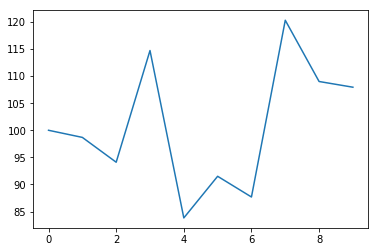

In [6]:
plt.plot(market_vals)

### Simulate market betas and idiosyncratic alphas within pre-defined ranges

In [7]:
beta_min = 0.05
beta_max = 0.85
beta_vals = np.random.uniform(low=beta_min, high=beta_max, size=num_risky_assets)

alpha_min = - 0.05
alpha_max = 0.15
alpha_vals = np.random.uniform(low=alpha_min, high=alpha_max, size=num_risky_assets)

print(beta_vals[0:10])
print(alpha_vals[0:10])

[0.11937829 0.1386877  0.34480733 0.68116194 0.81281243 0.1683684
 0.69977955 0.47880461 0.66277377 0.4520171 ]
[ 0.10505256  0.12190615  0.03944898  0.01193468 -0.04484332  0.09187051
 -0.00174146  0.1299544   0.12674252  0.10638753]


### Simulate time-dependent expected returns

In [8]:
# time-independent expected returns would be equal to alpha + beta * expected_market_return 
# make them time-dependent (and correlated with actual returns) as alpha + beta * oracle_market_returns
# oracle expected returns pick into the future! 

oracle_coeff = 0.2
mu_vec = mu_market * np.ones(num_steps)
oracle_market_returns = mu_vec * dt + oracle_coeff*(returns_market - mu_vec) 

expected_risky_returns = np.zeros((num_steps, num_risky_assets))

for t in range(num_steps):
    expected_risky_returns[t,:] = alpha_vals * dt + beta_vals * oracle_market_returns[t]

### Initial values of all assets 

In [9]:
val_min = 20.0
val_max = 120.0

init_risky_asset_vals = np.random.uniform(low=val_min, high=val_max, size=num_risky_assets)

### Simulate realized returns and asset prices

In [15]:
# make realized returns and realized asset values by simulating from a one-factor model 
# with time-dependent expected returns

risky_asset_returns = np.zeros((num_steps, num_risky_assets))
risky_asset_vals = np.zeros((num_steps, num_risky_assets))

idiosync_vol =  0.05 # vol_market #  

for t in range(num_steps):
    
    rand_norm = np.random.randn(num_risky_assets)
        
    # asset returns are simulated from a one-factor model
    risky_asset_returns[t,:] = (expected_risky_returns[t,:] + beta_vals * (returns_market[t] - mu_market * dt) 
                         + idiosync_vol * np.sqrt(1 - beta_vals**2) * np.sqrt(dt) * rand_norm)
        
    # asset values
    if t == 0:
        risky_asset_vals[t,:] = init_risky_asset_vals
    else:
        risky_asset_vals[t] = risky_asset_vals[t-1] * (1 + risky_asset_returns[t,:])
   

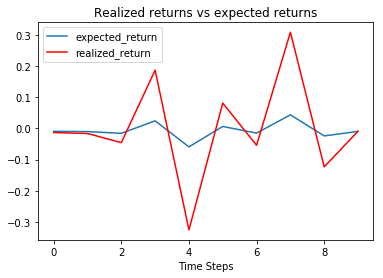

In [16]:
# compare the realized and expected returns
# Note that they appear correlated - this is because we constructed them so!

# pick a random asset to show
asset_idx =  4 # 8 # 6 # 5

plt.plot(expected_risky_returns[:,asset_idx],label='expected_return')
plt.plot(risky_asset_returns[:,asset_idx],label='realized_return',color='r')
plt.legend()
plt.xlabel('Time Steps')
plt.title('Realized returns vs expected returns')
plt.show()


### Compute the empirical correlation matrix using realized returns

In [17]:
cov_mat_r = np.cov(risky_asset_returns.T) 

print(cov_mat_r.shape)

D,v = np.linalg.eigh(cov_mat_r)

eigenvals = D[::-1]  # put them in a descended order

(99, 99)


In [18]:
# eigenvalues: the largest one is the market factor!
# the largest eigenvalue is the market factor 
eigenvals[0:10]

array([9.53754430e-01, 9.02297632e-03, 8.05099890e-03, 6.98606594e-03,
       5.78881463e-03, 4.53857041e-03, 3.68265608e-03, 3.46803333e-03,
       3.22563501e-03, 2.21095048e-16])

### Add a riskless bond as one more asset

In [19]:
num_assets = num_risky_assets + 1

bond_val = 100.0

# add the bond to initial assets
init_asset_vals = np.hstack((np.array([bond_val]),
                            init_risky_asset_vals))

### Make the initial portfolio 

In [20]:
# consider here two choices: equal or equally-weighted 

init_port_choice =  'equal' # 'equally_weighted'  #

init_cash = 1000.0
init_total_asset = np.sum(init_asset_vals)

x_vals_init = np.zeros(num_assets)

if init_port_choice == 'equal': 
    # hold equal amounts in each asset
    amount_per_asset = init_cash/num_assets
    x_vals_init = amount_per_asset * np.ones(num_assets)

elif init_port_choice == 'equally_weighted':
    amount_per_asset = init_cash/init_total_asset
    x_vals_init = amount_per_asset * init_asset_vals
    


### Make the target portfolio

In [21]:
# make a target portfolio term structure by defining it as the initial portfolio growing at some fixed and high rate

target_portfolio = [init_cash]

target_return = 0.15 # 0.20
coeff_target = 1.1 # 1.2 # 1.0

for i in range(1,num_steps):
    target_portfolio.append(target_portfolio[i-1]*np.exp(dt * target_return) )
    
target_portfolio = coeff_target*np.array(target_portfolio)    
print(target_portfolio[0], target_portfolio[-1])

1100.0 1541.5835692311712


## Train G-learning on simulated data

In [25]:
riskfree_rate = 0.02
fee_bond = 0.05 # 0.01 # 
fee_stock = 0.1 # 0.05 # 20.0 # 0.1 # 1.0 # 100 # 1.0 # 0.5 

# noticed much worse convergence for fee_stock = 0.2
# it converges for fee_stock = 0.5, but it converges faster for fee_stock=1

all_fees = np.zeros(num_risky_assets + 1)
all_fees[0] = fee_bond
all_fees[1:] = fee_stock
Omega_mat = np.diag(all_fees)


# model parameters
lambd = 1.0 # 0.02 # 0.05 # 0.07 # 0.1 # 0.15 # 0.1 # 0.15 # 0.1 # 0.1 # 50 # 10.0
beta = 0.5 # 1.0 # 50 # 50.0 # 1.0 # 10 # 10.0 # 0.2
gamma = 0.99 # 0.95

lambd = 2000 # 2000 # 2000 # 5000 # 10000 # 2000 # 0.01 # 0.05 # 0.5 # 0.1 # 1.0
beta = 350 # 300 # 200 # 100 # 10 # 1.0 # 0.2 # 0.1 # 0.2
gamma = 0.99 # 0.95


Sigma_r = cov_mat_r


# create a G-learner
G_learner = G_learning_portfolio_opt(num_steps,
                 lambd, 
                 Omega_mat, # eta,
                 beta,
                 gamma, 
                 num_risky_assets,
                 riskfree_rate,
                 expected_risky_returns, # array of shape num_steps x num_stocks
                 Sigma_r,     # covariance matrix of returns of risky matrix                    
                 x_vals_init, # array of initial values of len (num_stocks+1)
                 use_for_WM = True, # use for wealth management tasks
                 target_portf=target_portfolio)



In [26]:
# Do G-learning

err_tol=1.e-5 # 5.0e-5 # 1.0e-4
max_iter=500

t_0 = time.time()

# G_learner.step(t=num_steps-2,err_tol=1.0e-4, max_iter=50)
G_learner.G_learning(err_tol=err_tol, max_iter=max_iter)

# print('Done in %d iterations'% G_learner.iter_count)
print('Done in %f sec'% (time.time() - t_0))

Doing G-learning, it may take a few seconds...
Done in 1.313348 sec


In [27]:
G_learner.iter_counts

array([53., 32., 26.,  9.,  8.,  8.,  8.,  8., 42.,  0.])

## Results of G-learning

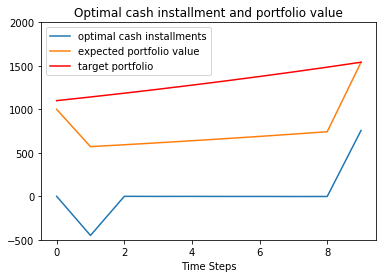

In [28]:
G_learner.project_cash_injections()


plt.plot(G_learner.expected_c_t, label='optimal cash installments')
plt.plot(G_learner.expected_portf_val, label='expected portfolio value')
plt.plot(G_learner.target_portf,label='target portfolio',color='r')

plt.legend()
plt.ylim(-500,2000)
plt.xlabel('Time Steps')
plt.title('Optimal cash installment and portfolio value')
plt.savefig('G_learning_wealth_unconstrained.png')
plt.show()